## Libraries to import

In [1]:
!pip install tensorflow
!pip install -q -U keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 kB 11.3 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt

Mounted at /content/drive


## Importing the dataset

In [3]:
all_prices = pd.read_csv('/content/drive/MyDrive/ml-datasets/currencies_prediction/prices_1h.csv')

### Feature engineering

In [4]:
# adding features that make more sense than raw data
# all_prices["Gold_ret"] = all_prices["Gold"].pct_change()
# all_prices["Silver_ret"] = all_prices["Silver"].pct_change()
# all_prices["CAD_ret"] = all_prices["CAD"].pct_change()

# all_prices["Gold_ma"] = all_prices["Gold"].rolling(5).mean()
# all_prices["Silver_ma"] = all_prices["Silver"].rolling(5).mean()
# all_prices["CAD_ma"] = all_prices["CAD"].rolling(5).mean()

In [5]:
all_prices = all_prices.dropna().drop(columns=['Datetime'])

In [6]:
all_prices.head()

,Gold,Silver,CAD
0,2136.500000,26.150000,0.740730
1,2115.600098,26.059999,0.740730
2,2107.699951,25.915001,0.740466
3,2108.199951,25.940001,0.740297
4,2105.500000,25.870001,0.739809


In [7]:
all_prices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12511 entries, 0 to 12510
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Gold    12511 non-null  float64
 1   Silver  12511 non-null  float64
 2   CAD     12511 non-null  float64
dtypes: float64(3)
memory usage: 293.4 KB


In [8]:
all_prices.describe()

,Gold,Silver,CAD
count,12511.000000,12511.000000,12511.000000
mean,2836.940654,32.635758,0.723850
std,602.589997,7.054973,0.015195
min,1989.300049,22.014999,0.676535
25%,2357.750000,28.600000,0.714344
50%,2678.500000,31.415001,0.726533
75%,3337.650024,34.802500,0.735078
max,4394.299805,58.564999,0.758392


In [9]:
scaler = MinMaxScaler()
scaled = scaler.fit_transform(all_prices)
scaled

array([[0.06120581, 0.1131327 , 0.78423446],
       [0.05251562, 0.11067032, 0.78423446],
       [0.04923073, 0.10670319, 0.78101817],
       ...,
       [0.95155925, 0.98837211, 0.47929403],
       [0.94989604, 0.98317379, 0.47929403],
       [0.95268199, 0.98180582, 0.47929403]])

In [10]:
def create_sequences(data, timesteps):
    X, y = [], []
    for i in range(len(data) - timesteps):
        X.append(data[i : i + timesteps])
        y.append(data[i + timesteps])
    return np.array(X), np.array(y)

In [11]:
max_window = 60

X, y = create_sequences(scaled, max_window)
X.shape

(12451, 60, 3)

### Train/test split

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=False)

## GRU implementation

### Hyperparameter tuning

In [13]:
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

def mae(y_true, y_pred):
    return tf.reduce_mean(tf.abs(y_true - y_pred))

def mape(y_true, y_pred):
    return tf.reduce_mean(tf.abs((y_true - y_pred) / (y_true + 1e-8))) * 100

In [14]:
def model_builder(hp):
    model = keras.Sequential([
        keras.layers.GRU(
            units=hp.Int("units_1", min_value=16, max_value=128, step=16),
            return_sequences=True,
            input_shape=(hp.Int("window", min_value=10, max_value=100, step=10), 3),
            kernel_regularizer=keras.regularizers.l2(hp.Choice("l2_reg", values=[1e-6, 1e-5, 1e-4]))
        ),
        keras.layers.Dropout(hp.Float("dropout_1", min_value=0.1, max_value=0.3, step=0.05)),
        keras.layers.GRU(
            units=hp.Int("units_2", min_value=8, max_value=64, step=8),
            return_sequences=False,
            kernel_regularizer=keras.regularizers.l2(hp.Choice("l2_reg2", [1e-6, 1e-5, 1e-4])),
        ),
        keras.layers.Dropout(hp.Float("dropout_2", min_value=0.1, max_value=0.3, step=0.05)),
        keras.layers.Dense(3, activation="relu") #output
    ])

    model.compile(
        optimizer=keras.optimizers.Adam(hp.Choice("learning_rate", [1e-2, 5e-3, 1e-3, 5e-4, 1e-4])),\
        loss="mse",
        metrics=[rmse, mae, mape]
    )

    return model

In [15]:
tuner = kt.Hyperband(
    model_builder,
    objective=kt.Objective("val_rmse", direction="min"),
    max_epochs=40,
    max_consecutive_failed_trials=5,
    seed=42,
    directory="tuning_results",
    project_name="gold_silver_cad",
)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [16]:
stop_early = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5
)

In [17]:
tuner.search(x=X_train, y=y_train, validation_split=0.15, callbacks=[stop_early])

Trial 90 Complete [00h 00m 48s]
val_rmse: 0.00689623411744833

Best val_rmse So Far: 0.00500192865729332
Total elapsed time: 00h 32m 15s


### Metrics evaluation of the best model

In [19]:
best_model = tuner.get_best_models(1)[0]
best_model.save('gru_1h.keras')
best_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 40, 128)        │        51,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 40, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 64)             │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 88,515 (345.76 KB)

 Trainable params: 88,515 (345.76 KB)

 Non-trainable params: 0 (0.00 B)

In [20]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_hps.values

{'units_1': 128,
 'window': 40,
 'l2_reg': 1e-06,
 'dropout_1': 0.1,
 'units_2': 64,
 'l2_reg2': 1e-06,
 'dropout_2': 0.15000000000000002,
 'learning_rate': 0.001,
 'tuner/epochs': 40,
 'tuner/initial_epoch': 14,
 'tuner/bracket': 2,
 'tuner/round': 2,
 'tuner/trial_id': '0067'}

In [21]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

model = best_model

y_pred = model.predict(X_test)

y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test)

rmse_val = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
mae_val  = mean_absolute_error(y_test_inv, y_pred_inv)
mape_val = mean_absolute_percentage_error(y_test_inv, y_pred_inv)

print("RMSE:", rmse_val)
print("MAE :", mae_val)
print("MAPE:", mape_val)

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
RMSE: 36.18532618629252
MAE : 17.952411488336722
MAPE: 0.00738373486652475


In [22]:
baseline = scaler.inverse_transform(X_test[:, -1, :])

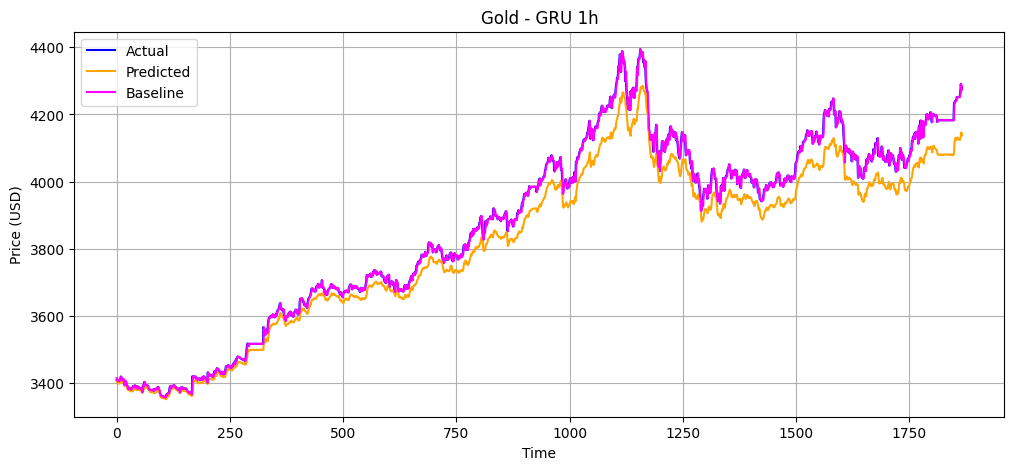

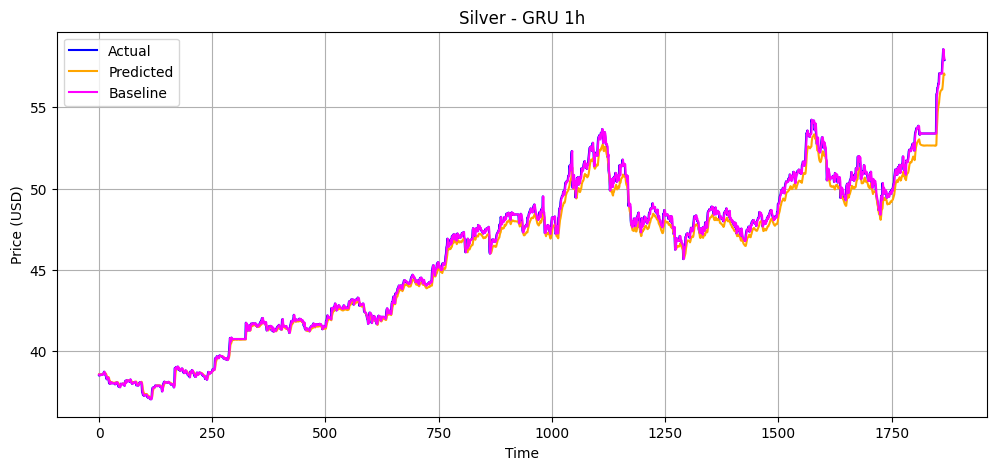

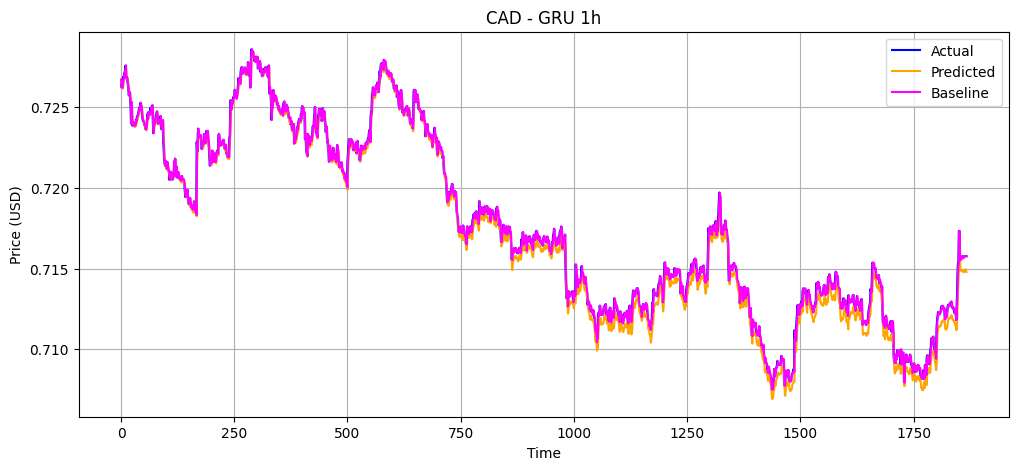

In [25]:
def plot_asset(i, asset_name):
    plt.figure(figsize=(12,5))
    plt.plot(y_test_inv[:, i], label="Actual", color="blue")
    plt.plot(y_pred_inv[:, i], label="Predicted", color="orange")
    plt.plot(baseline[:, i], label="Baseline", color="magenta")
    plt.title(f"{asset_name} - GRU 1h")
    plt.xlabel("Time")
    plt.ylabel("Price (USD)")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_asset(0, "Gold")
plot_asset(1, "Silver")
plot_asset(2, "CAD")

In [24]:
def mae(y, p): return np.mean(np.abs(y-p))
def rmse(y, p): return np.sqrt(np.mean((y-p)**2))
def mape(y, p): return np.mean(np.abs((y-p)/y))*100

assets = ["Gold","Silver","CAD"]
for i in range(3):
    print(assets[i])
    print(" MAE :", mae(y_test_inv[:,i], y_pred_inv[:,i]))
    print(" RMSE:", rmse(y_test_inv[:,i], y_pred_inv[:,i]))
    print(" MAPE:", mape(y_test_inv[:,i], y_pred_inv[:,i]))
    print()

Gold
 MAE : 53.46082470912239
 RMSE: 62.67270980018107
 MAPE: 1.3326798634889825

Silver
 MAE : 0.39591418803376327
 RMSE: 0.5147227777144888
 MAPE: 0.8132256588500315

CAD
 MAE : 0.0004955678540072548
 RMSE: 0.0006241405713456466
 MAPE: 0.06921493761841031



### Retrain a model with best HPs 10 times

To ensure the model did not randomly achieve good results with the test set

In [ ]:
mae_arr = []
rmse_arr = []
mape_arr = []

for i in range(10):

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=False)

  model = keras.Sequential([
      keras.layers.GRU(
          units=best_hps.values["units_1"],
          return_sequences=True,
          input_shape=(best_hps.values["window"], 3),
          kernel_regularizer=best_hps.values["l2_reg"]
      ),
      keras.layers.Dropout(best_hps.values["dropout_1"]),
      keras.layers.GRU(
          units=best_hps.values["units_2"],
          return_sequences=False,
          kernel_regularizer=best_hps.values["l2_reg"],
      ),
      keras.layers.Dropout(best_hps.values["dropout_2"]),
      keras.layers.Dense(3, activation="relu") #output
  ])

  model.compile(
      optimizer=keras.optimizers.Adam(best_hps.values["learning_rate"]),
      loss='mse',
      metrics=[rmse, mae, mape]
  )

  model.fit(X_train, y_train, epochs=best_hps.values['tuner/epochs'])

  y_pred = model.predict(X_test)

  y_pred_inv = scaler.inverse_transform(y_pred)
  y_test_inv = scaler.inverse_transform(y_test)

  rmse_val = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
  mae_val  = mean_absolute_error(y_test_inv, y_pred_inv)
  mape_val = mean_absolute_percentage_error(y_test_inv, y_pred_inv)

  print("RMSE:", rmse_val)
  print("MAE :", mae_val)
  print("MAPE:", mape_val)